# Mnist

## Code

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

## Viendo los datos

In [3]:


mnist = fetch_openml('mnist_784', as_frame=False)
mnist.DESCR

c:\Users\brais.fernandezvazqu\Miniconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* X = variable of values to use for training
* Y = variable of values to predict

In [5]:
x = mnist['data']
y = mnist['target'].astype(np.uint8)

Mostrar el primer valor de X e Y


El primer valor es:  5


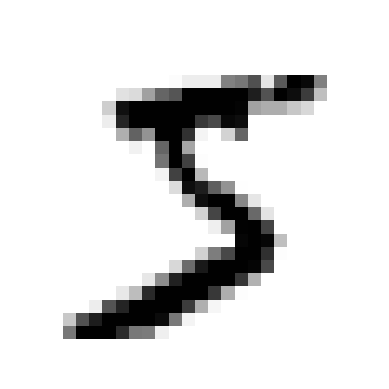

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(x[0])
print("El primer valor es: ",y[0])

Mostrar los 100 primeros valores de X

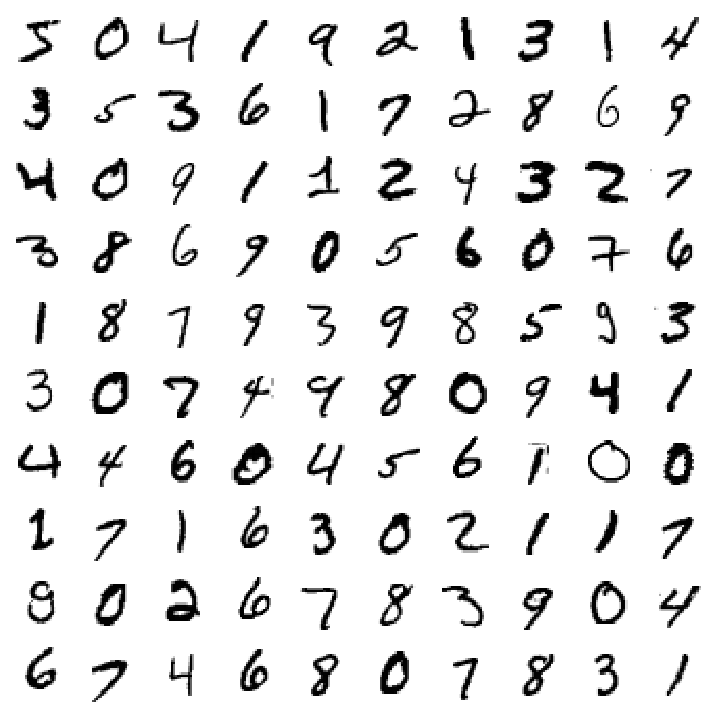

In [7]:
plt.figure(figsize=(9,9))
for i in range(100):
    plt.subplot(10,10,i+1)
    plot_digit(x[i])

## Crear los datos de entrenamiento y de test

Como el dataset ya está desordenado, no es necesario desordenarlo para separar los datos de entrenamiento y prueba

In [8]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

## Entrenando para clasificar si un numero es un 5 o no

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Al igual que con el regresor lineal, se puede entrenar un clasificador binario para clasificar

In [10]:
from sklearn.linear_model import SGDClassifier
sdg_clasifier = SGDClassifier(random_state=42)
sdg_clasifier.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
def print_es_5(val):
    print("El valor","es 5" if val else "no es 5")

El valor es 5


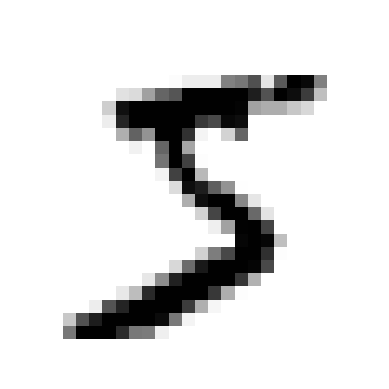

In [12]:
val = sdg_clasifier.predict([x[0]])
print_es_5(val[0])
plot_digit(x[0])

El valor no es 5


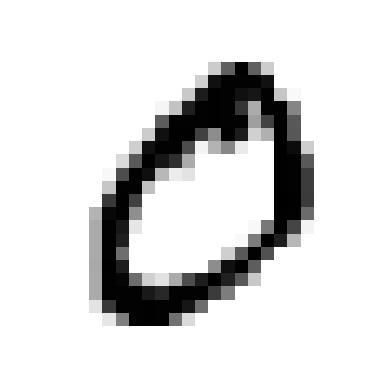

In [13]:
val =sdg_clasifier.predict([x[1]])
print_es_5(val[0])
plot_digit(x[1])

### Validación cruzada

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sdg_clasifier)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sdg_clasifier, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Creando un clasificador que nunca predice 5 para comparar

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Vemos que el 10% de los valores son 5, por lo que si siempre predijéramos que no es 5, tendríamos un 90% de acierto. Entonces no podemos fiarnos de la precisión como métrica de evaluación.

## Matriz de confusión

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sdg_clasifier, x_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Precision y recall

In [19]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print("Precision: ", precision)
print("Recall: ", recall)



Precision:  0.8370879772350012
Recall:  0.6511713705958311


F1 score
(Media armónica de precision y recall)

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

In [21]:
y_scores = cross_val_predict(sdg_clasifier, x_train, y_train_5, cv=3, method="decision_function")

en vez de devolver un valor booleano, devuelve una probabilidad no normalizada de que sea 5

In [22]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

### Graficar los umbrales

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

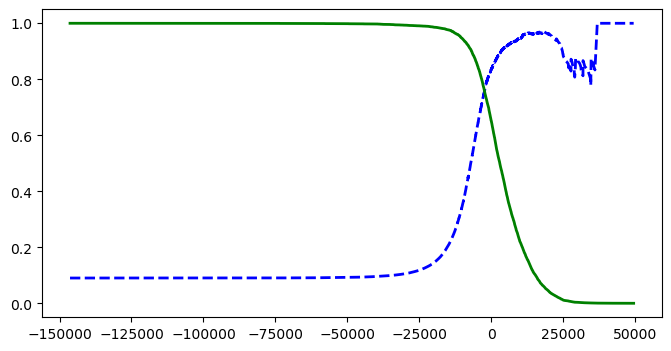

In [24]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)


plt.show()

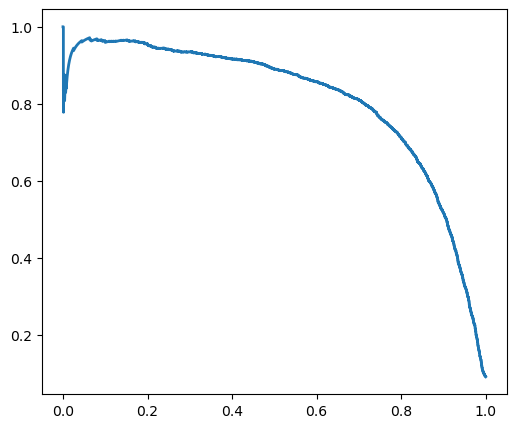

In [25]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

### Curva ROC

Cuanto mayor sea el área bajo la curva, mejor será el clasificador

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

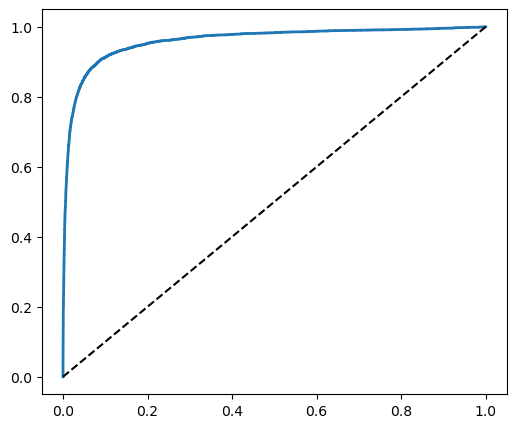

In [28]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k--')

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [32]:
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

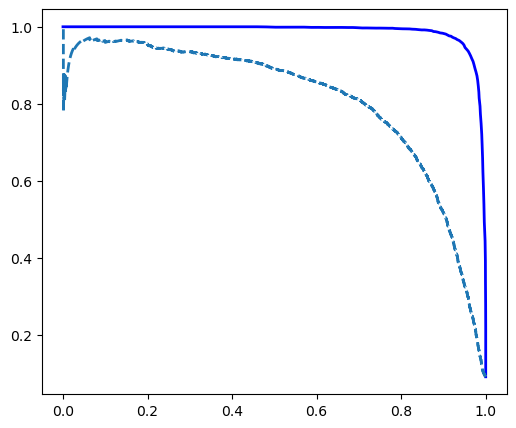

In [34]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")